In [16]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.utils import check_random_state

plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)

DATA_TRANSFORMED = "../data/transformed"
TRAIN_FEAT = os.path.join(DATA_TRANSFORMED, "train-features.parquet")
TEST_FEAT = os.path.join(DATA_TRANSFORMED, "test-features.parquet")

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [17]:
# def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
#     for c in df.select_dtypes(include=["float64"]).columns:
#         df[c] = df[c].astype("float32")
#     for c in df.select_dtypes(include=["int64", "int32"]).columns:
#         if c == "item_contact":
#             df[c] = df[c].astype("int8")
#         else:
#             df[c] = df[c].astype("int32")
#     return df


train = pd.read_parquet(TRAIN_FEAT)
test = pd.read_parquet(TEST_FEAT)

# train = downcast_df(train)
# test = downcast_df(test)

print(train.shape, test.shape)
train.head()


(342886, 68) (335348, 67)


,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,...,tfidf_cosine_title_z_in_q,tfidf_cosine_title_mm_in_q,tfidf_cosine_desc_z_in_q,tfidf_cosine_desc_mm_in_q,click_conv_log_z_in_q,click_conv_log_mm_in_q,tfidf_title_x_init,price_rank_x_init,ctr_z_x_init,top3_x_match_cat
0,112133,4479307056,памперсы для взрослых,Памперсы для взрослых l 30 штук,несколько упаковок в наличии,88,430,624030,88,430,...,-0.892003,0.000000,-1.046035,0.000000,2.041241,1.0,0.187780,0.416667,1.020621,1
1,112133,2531208467,памперсы для взрослых,Памперсы для взрослых Senso,Памперсы для взрослых Senso\r\nРазмер Medium,88,430,624030,88,430,...,0.268061,0.439907,0.274262,0.466828,-0.408248,0.0,0.216752,0.111111,-0.136083,1
2,112133,4427760183,памперсы для взрослых,Памперсы для взрослых Senso,Подгузники для взрослых. Размер М (70-120 см)....,88,430,624030,88,430,...,0.268061,0.439907,-0.752281,0.103865,-0.408248,0.0,0.162564,0.145833,-0.102062,1
3,112133,2390887700,памперсы для взрослых,Памперсы для взрослых 4 размер xl,Памперсы для взрослых,88,430,624030,88,430,...,-0.853453,0.014618,1.782197,1.000000,-0.408248,0.0,0.076938,0.200000,-0.081650,0
4,112133,1960921837,памперсы для взрослых,Памперсы для взрослых,Памперсы для взрослых. Seni.Размер 1(Smal). В ...,88,430,624030,88,430,...,1.745060,1.000000,-0.295087,0.265519,-0.408248,0.0,0.166667,0.097222,-0.068041,0


In [18]:
train.columns

Index(['query_id', 'item_id', 'query_text', 'item_title', 'item_description',
       'query_cat', 'query_mcat', 'query_loc', 'item_cat_id', 'item_mcat_id',
       'item_loc', 'price', 'item_query_click_conv', 'item_contact',
       'initial_rank', 'initial_rank_inv', 'initial_rank_pct', 'init_in_top1',
       'init_in_top3', 'init_in_top10', 'price_log', 'price_norm', 'is_free',
       'price_z_in_query', 'price_is_zero', 'price_lt_cat_median',
       'price_gt_cat_p90', 'price_over_median_cat_loc', 'has_num_in_query',
       'num_match_in_title', 'num_match_in_desc', 'unit_match_in_title',
       'unit_match_in_desc', 'num_or_unit_match_any',
       'num_and_unit_both_match_any', 'match_cat', 'match_mcat', 'match_loc',
       'click_conv', 'click_conv_log', 'click_conv_log_z_in_query',
       'query_text_len_chars', 'query_text_len_words', 'item_title_len_chars',
       'item_title_len_words', 'item_description_len_chars',
       'item_description_len_words', 'q_in_title_frac', 'q_in_

In [19]:
ID_COLS = ["query_id", "item_id"]
TARGET_COL = "item_contact"

drop_cols = [
    # идентификаторы
    "query_id",
    "item_id",
    # тексты
    "query_text",
    "item_title",
    "item_description",
    # сырые категориальные айди (есть match_* и freq_* замены)
    "query_cat",
    "query_mcat",
    "query_loc",
    "item_cat_id",
    "item_mcat_id",
    "item_loc",
    # таргет
    TARGET_COL,
    # дубликаты ценовых
    "price",
    # дубликаты CTR
    "click_conv",
    "click_conv_log",
    "click_conv_log_mm_in_q",
    "click_conv_log_z_in_q",
    # длины в символах (оставляем *_len_words)
    "query_text_len_chars",
    "item_title_len_chars",
    "item_description_len_chars",
    # нули и мусор
    "price_norm",
    "price_is_zero",
    "init_in_top1",
    "init_in_top3",
    "init_in_top10",
    "unit_match_in_title",
    "unit_match_in_desc",
    "num_and_unit_both_match_any",
    # слабые матчинги
    "q_in_title_frac",
    "q_in_desc_frac",
    "match_cat",
    "match_mcat",
    "match_loc",
    "top3_x_match_cat",
    # слабые числовые/бинарки
    "is_free",
    "has_num_in_query",
    "num_match_in_title",
    "num_match_in_desc",
    "num_or_unit_match_any",
    "price_lt_cat_median",
    "price_gt_cat_p90",
    # дубликаты рангов
    "initial_rank_inv",
    # дубликаты tf-idf
    "tfidf_cosine_title",
    "tfidf_cosine_desc",
    "tfidf_cosine_title_mm_in_q",
    "tfidf_cosine_desc_mm_in_q",
]

FEATURE_COLS = [c for c in train.columns if c not in drop_cols]

X = train[FEATURE_COLS].copy()
y = train[TARGET_COL].astype("float32").values
groups = train["query_id"].values

print("n_features:", len(FEATURE_COLS))
print(FEATURE_COLS)


n_features: 22
['item_query_click_conv', 'initial_rank', 'initial_rank_pct', 'price_log', 'price_z_in_query', 'price_over_median_cat_loc', 'click_conv_log_z_in_query', 'query_text_len_words', 'item_title_len_words', 'item_description_len_words', 'tfidf_rank_in_query', 'price_rank_in_query', 'item_cat_loc_freq', 'query_loc_freq', 'item_loc_freq', 'item_cat_id_freq', 'item_mcat_id_freq', 'tfidf_cosine_title_z_in_q', 'tfidf_cosine_desc_z_in_q', 'tfidf_title_x_init', 'price_rank_x_init', 'ctr_z_x_init']


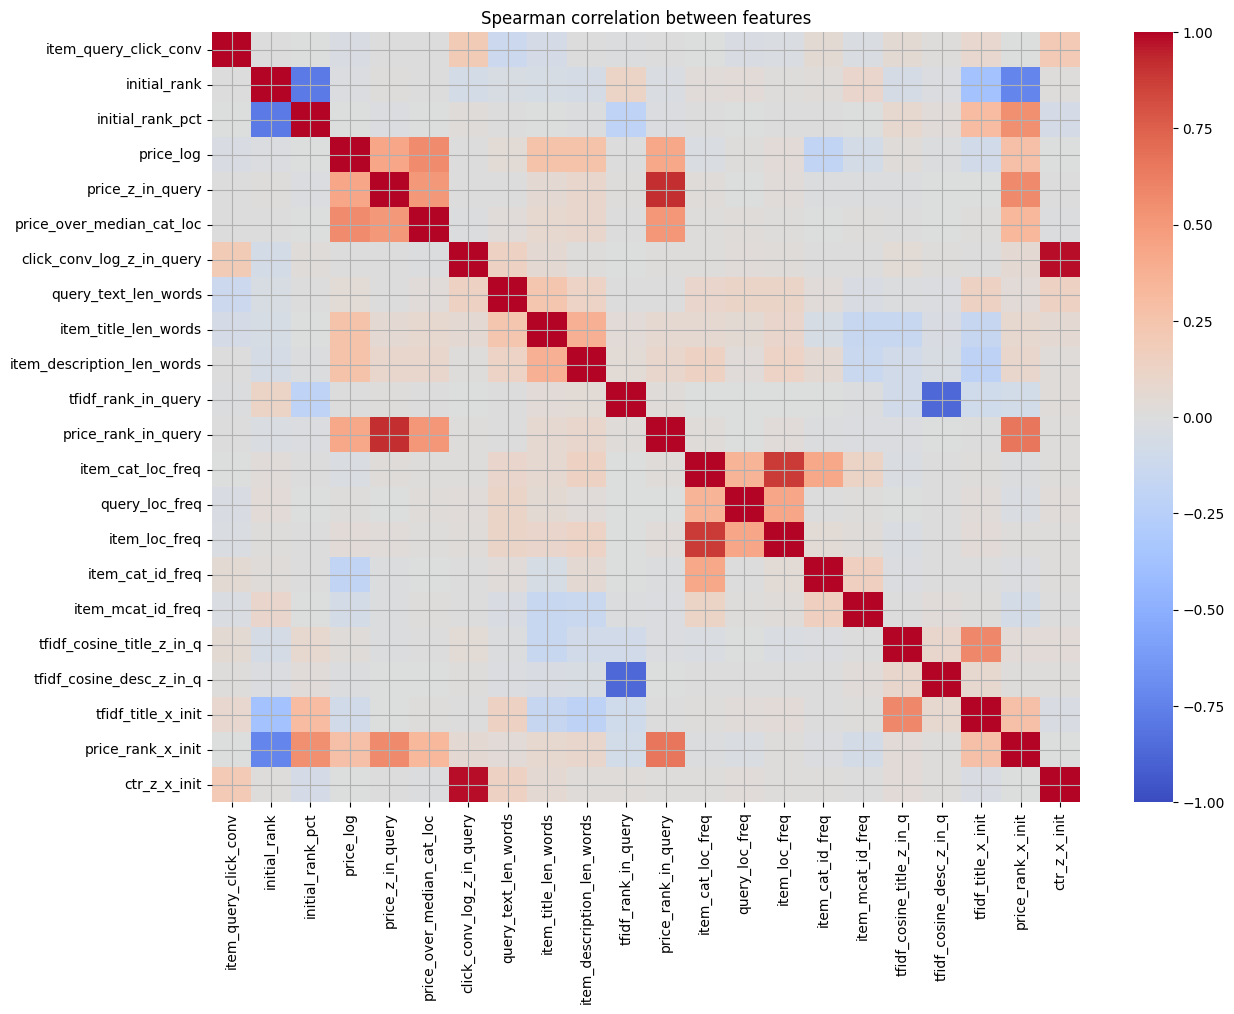

initial_rank                 -0.063214
price_log                    -0.058202
item_title_len_words         -0.033258
price_over_median_cat_loc    -0.030218
query_loc_freq               -0.022209
tfidf_rank_in_query          -0.021846
item_loc_freq                -0.021844
price_z_in_query             -0.017837
price_rank_in_query          -0.014621
item_description_len_words   -0.014500
query_text_len_words         -0.013004
item_cat_loc_freq            -0.000817
ctr_z_x_init                  0.010492
click_conv_log_z_in_query     0.014680
item_mcat_id_freq             0.015698
item_query_click_conv         0.016238
tfidf_cosine_desc_z_in_q      0.018906
tfidf_cosine_title_z_in_q     0.034767
price_rank_x_init             0.037019
tfidf_title_x_init            0.050348
item_cat_id_freq              0.051136
initial_rank_pct              0.090531
dtype: float64


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# только числовые колонки
num_cols = train[FEATURE_COLS].select_dtypes(include=["number"]).columns

# корреляция признаков между собой (Spearman чаще осмысленнее для фичей)
corr = train[num_cols].corr(method="spearman")

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Spearman correlation between features")
plt.show()

# корреляция с таргетом
corr_target = (
    train[num_cols].corrwith(train[TARGET_COL], method="spearman").sort_values()
)
print(corr_target)


In [21]:
def calc_dcg_at_k(v: np.ndarray, k: int = 10) -> float:
    w = 0.97 ** np.arange(len(v))
    return (v * w)[:k].sum()


def calc_idcg_at_k(v: np.ndarray, k: int = 10) -> float:
    return calc_dcg_at_k(np.sort(v)[::-1], k)


def calc_ndcg_at_k(v: np.ndarray, k: int = 10) -> float:
    denom = calc_idcg_at_k(v, k)
    if denom == 0:
        return 0.0
    return calc_dcg_at_k(v, k) / denom


def ndcg_at_10_by_queries(
    y_true: np.ndarray, y_pred: np.ndarray, qids: np.ndarray, k: int = 10
) -> float:
    order = np.argsort(qids, kind="mergesort")
    qids_sorted = qids[order]
    y_true_s = y_true[order]
    y_pred_s = y_pred[order]

    uniq, starts = np.unique(qids_sorted, return_index=True)
    starts = list(starts) + [len(qids_sorted)]

    scores = []
    for i in range(len(uniq)):
        s, e = starts[i], starts[i + 1]
        yt = y_true_s[s:e]
        yp = y_pred_s[s:e]
        idx = np.argsort(-yp, kind="mergesort")
        v = yt[idx]
        scores.append(calc_ndcg_at_k(v, k))
    return float(np.mean(scores)) if scores else 0.0


def lgbm_ndcg10_custom(preds, dataset, k: int = 10):
    """
    Кастомная метрика для LightGBM — NDCG@10 с decay 0.97^rank.
    """
    y = dataset.get_label().astype(np.int32)
    group = dataset.get_group().astype(int)
    qids = np.repeat(np.arange(len(group)), group)

    # сортируем по qid
    order = np.argsort(qids, kind="mergesort")
    y_s = y[order]
    p_s = preds[order]
    q_s = qids[order]

    uniq, starts = np.unique(q_s, return_index=True)
    starts = np.r_[starts, len(q_s)]

    scores = []
    for i in range(len(uniq)):
        s, e = starts[i], starts[i + 1]
        yt = y_s[s:e]
        if yt.max() == 0:  # нет релевантных документов → пропускаем
            continue
        yp = p_s[s:e]
        idx = np.argsort(-yp, kind="mergesort")
        v = yt[idx]
        w = 0.97 ** np.arange(len(v))
        dcg = (v * w)[:k].sum()
        idcg = (np.sort(v)[::-1] * w)[:k].sum()
        scores.append(dcg / idcg if idcg > 0 else 0.0)

    score = float(np.mean(scores)) if scores else 0.0
    return "ndcg10_custom", score, True

In [22]:
N_SPLITS = 3
gkf = GroupKFold(n_splits=N_SPLITS)

params = {
    "objective": "lambdarank",
    "label_gain": [0, 1],
    "lambdarank_truncation_level": 10,
    "metric": "None",
    "eval_at": [10],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "min_data_in_leaf": 100,
    "min_gain_to_split": 0.0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
    "lambda_l1": 0.0,
    "max_bin": 127,
    "verbosity": -1,
    "seed": RANDOM_STATE,
    "feature_fraction_seed": RANDOM_STATE,
    "bagging_seed": RANDOM_STATE,
    "data_random_seed": RANDOM_STATE,
    "deterministic": True,
    "force_row_wise": True,
}


oof_pred = np.zeros(len(train), dtype=np.float32)
models = []
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, y_tr, q_tr = X.iloc[tr_idx], y[tr_idx], groups[tr_idx]
    X_va, y_va, q_va = X.iloc[va_idx], y[va_idx], groups[va_idx]

    def group_sizes(qids):
        _, counts = np.unique(qids, return_counts=True)
        return counts

    lgb_tr = lgb.Dataset(X_tr, y_tr, group=group_sizes(q_tr), free_raw_data=False)
    lgb_va = lgb.Dataset(
        X_va, y_va, group=group_sizes(q_va), reference=lgb_tr, free_raw_data=False
    )

    booster = lgb.train(
        params,
        lgb_tr,
        num_boost_round=10_000,
        valid_sets=[lgb_tr, lgb_va],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200, verbose=False),
            lgb.log_evaluation(period=200),
        ],
        feval=lgbm_ndcg10_custom,
    )

    pred_va = booster.predict(X_va, num_iteration=booster.best_iteration)
    oof_pred[va_idx] = pred_va

    ndcg10 = ndcg_at_10_by_queries(y_va, pred_va, q_va, k=10)
    fold_scores.append(ndcg10)
    models.append(booster)

    print(f"[Fold {fold}] best_iter={booster.best_iteration}  NDCG@10={ndcg10:.5f}")


[200]	train's ndcg10_custom: 0.963007	valid's ndcg10_custom: 0.919703
[400]	train's ndcg10_custom: 0.980222	valid's ndcg10_custom: 0.91812
[Fold 1] best_iter=251  NDCG@10=0.31471
[200]	train's ndcg10_custom: 0.962996	valid's ndcg10_custom: 0.92291
[Fold 2] best_iter=93  NDCG@10=0.32706
[200]	train's ndcg10_custom: 0.963291	valid's ndcg10_custom: 0.917041
[Fold 3] best_iter=195  NDCG@10=0.32302


OOF NDCG@10 (на всех фолдах): 0.32160


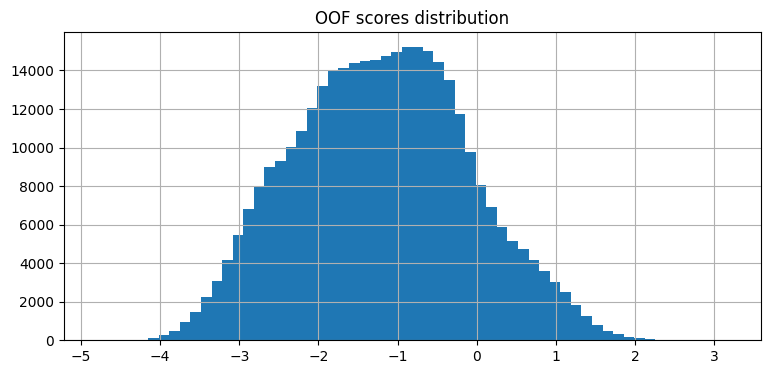

In [23]:
oof_ndcg10 = ndcg_at_10_by_queries(y_true=y, y_pred=oof_pred, qids=groups, k=10)
print(f"OOF NDCG@10 (на всех фолдах): {oof_ndcg10:.5f}")

plt.figure()
plt.hist(oof_pred, bins=60)
plt.title("OOF scores distribution")
plt.show()


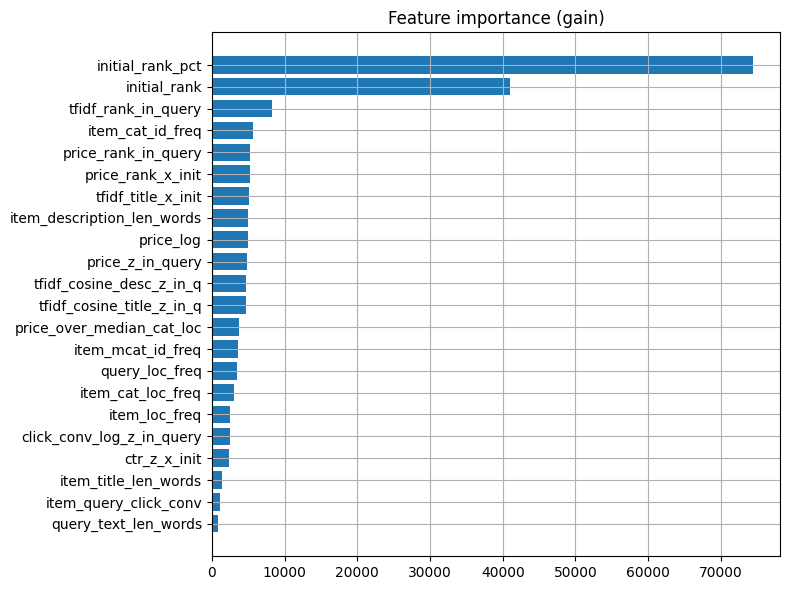

,feature,gain
2,initial_rank_pct,74399.139244
1,initial_rank,40976.928394
10,tfidf_rank_in_query,8251.251665
15,item_cat_id_freq,5593.408042
11,price_rank_in_query,5295.928677
20,price_rank_x_init,5179.309711
19,tfidf_title_x_init,5098.824900
9,item_description_len_words,4968.927374
3,price_log,4958.863980
4,price_z_in_query,4781.204910


In [24]:
importances = pd.DataFrame(
    {
        "feature": FEATURE_COLS,
        "gain": np.mean(
            [m.feature_importance(importance_type="gain") for m in models], axis=0
        ),
    }
)
imp_top = importances.sort_values("gain", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"][::-1], imp_top["gain"][::-1])
plt.title("Feature importance (gain)")
plt.tight_layout()
plt.show()

imp_top


In [25]:
def group_sizes_ordered(qids: np.ndarray) -> np.ndarray:
    _, counts = np.unique(qids, return_counts=True)
    return counts


train_full = lgb.Dataset(X, y, group=group_sizes_ordered(groups), free_raw_data=False)

final_model = lgb.train(
    params,
    train_full,
    num_boost_round=int(np.mean([m.best_iteration for m in models])),
    valid_sets=[train_full],
    valid_names=["train"],
    callbacks=[lgb.log_evaluation(period=200)],
)

final_path = os.path.join(MODEL_DIR, "lgbm_ranker.txt")
final_model.save_model(final_path)
print("Saved model to:", final_path)


Saved model to: ../models/lgbm_ranker.txt


In [26]:
oof_df = train[["query_id", "item_id", TARGET_COL]].copy()
oof_df["oof_score"] = oof_pred.astype("float32")
oof_out = os.path.join(DATA_TRANSFORMED, "oof_scores.parquet")
oof_df.to_parquet(oof_out, index=False)
print("Saved OOF:", oof_out)

test_scores = test[["query_id", "item_id"]].copy()
test_scores["score"] = final_model.predict(test[FEATURE_COLS])
test_out = os.path.join(DATA_TRANSFORMED, "test_scores.parquet")
test_scores.to_parquet(test_out, index=False)
print("Saved test scores:", test_out)


Saved OOF: ../data/transformed/oof_scores.parquet
Saved test scores: ../data/transformed/test_scores.parquet


In [27]:
sub = test_scores.sort_values(["query_id", "score"], ascending=[True, False])[
    ["query_id", "item_id"]
]
sub_path = os.path.join("../data", "solution.csv")
sub.to_csv(sub_path, header=["query_id", "item_id"], index=False)
print("Saved submission:", sub_path)
sub.head()


Saved submission: ../data/solution.csv


,query_id,item_id
1,55,7506720336
3,55,7587733901
0,55,7540855789
4,55,7552455685
5,55,7264508669
